# [0. Database 연동]

In [ ]:
!pip install mysql-connector-python

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ca.pem to ca (1).pem


In [ ]:
import mysql.connector

# DB 연결


In [ ]:
from datetime import datetime
import tensorflow as tf

class MySQLLogger(tf.keras.callbacks.Callback):
    def __init__(self, model_name, conn, test_data=None):
        super().__init__()
        self.model_name = model_name
        self.conn = conn
        self.cursor = conn.cursor()
        self.test_data = test_data #test 데이터셋 전달받기

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = datetime.now()

    def on_epoch_end(self, epoch, logs=None):
        end_time = datetime.now()
        loss = logs.get('loss')
        acc = logs.get('accuracy')
        val_loss = logs.get('val_loss')
        val_acc = logs.get('val_accuracy')

        # test 데이터는 학습이 끝난 후 한 번만 평가할 수 있으므로,
        # 여기서는 epoch 마다 평가하지 않음.

        self.cursor.execute(
            "INSERT INTO training_logs (model_name, epoch, start_time, end_time, loss, accuracy, val_loss, val_accuracy) VALUES (%s, %s, %s, %s, %s, %s, %s, %s)",
            (self.model_name, epoch + 1, self.start_time, end_time, loss, acc, val_loss, val_acc)
        )
        self.conn.commit()

    def on_train_end(self, logs=None):
        if self.test_data:
          test_loss, _ = self.model.evaluate(self.test_data, verbose=0)
          self.cursor.execute(
                "UPDATE training_logs SET test_loss = %s WHERE model_name = %s ORDER BY epoch DESC LIMIT 1",
                (test_loss, self.model_name))
          self.conn.commit()
        self.cursor.close()


# [1. 필요한 라이브러리 설치]

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU 디바이스:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU 디바이스: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import files
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAvgPool2D
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, ResNet50V2, VGG16, MobileNetV2
from sklearn.metrics import confusion_matrix, classification_report

# [2. 데이터셋 다운로드 준비]

In [ ]:
# 구글 코랩에서 데이터셋 다운로드 및 준비
files.upload() # 'kaggle.json' 파일 업로드

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Vegetable Image 데이터셋 다운로드
!kaggle datasets download -d misrakahmed/vegetable-image-dataset

# 압축 해제
!unzip vegetable-image-dataset.zip -d vegetable-image

# 데이터셋 파일 목록 출력
!ls -l
print("\n데이터 확인")
!ls -l vegetable-image
print("\n폴더 내부 구조 확인")
!ls -l vegetable-image/*

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: vegetable-image/Vegetable Images/train/Radish/0021.jpg  
  inflating: vegetable-image/Vegetable Images/train/Radish/0022.jpg  
  inflating: vegetable-image/Vegetable Images/train/Radish/0023.jpg  
  inflating: vegetable-image/Vegetable Images/train/Radish/0024.jpg  
  inflating: vegetable-image/Vegetable Images/train/Radish/0025.jpg  
  inflating: vegetable-image/Vegetable Images/train/Radish/0026.jpg  
  inflating: vegetable-image/Vegetable Images/train/Radish/0027.jpg  
  inflating: vegetable-image/Vegetable Images/train/Radish/0028.jpg  
  inflating: vegetable-image/Vegetable Images/train/Radish/0029.jpg  
  inflating: vegetable-image/Vegetable Images/train/Radish/0030.jpg  
  inflating: vegetable-image/Vegetable Images/train/Radish/0031.jpg  
  inflating: vegetable-image/Vegetable Images/train/Radish/0032.jpg  
  inflating: vegetable-image/Vegetable Images/train/Radish/0033.jpg  
  inflating: vegetable-image/Vegetable Images/train/Ra

# [3. 데이터 전처리]

In [ ]:
# 경로 설정
train_path = "vegetable-image/Vegetable Images/train"
test_path = "vegetable-image/Vegetable Images/test"
validation_path = "vegetable-image/Vegetable Images/validation"

# 데이터 증강 (Data Augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,              # 픽셀 값 정규화 (0~1)
    rotation_range=30,           # 최대 30도 회전
    width_shift_range=0.2,       # 가로 이동 (20%)
    height_shift_range=0.2,      # 세로 이동 (20%)
    shear_range=0.2,             # 기울이기 변형
    zoom_range=0.2,              # 확대/축소 (20%)
    horizontal_flip=True,        # 좌우 반전
    brightness_range=[0.8, 1.2], # 밝기 변화 (80%~120%)
    fill_mode='nearest')          # 변환 후 빈 공간 보정

# 검증 및 테스트 데이터는 증강 없이 정규화만 적용
valid_test_datagen = ImageDataGenerator(rescale=1./255)

class_names = sorted(os.listdir(train_path))
num_classes = len(class_names)

# 학습 데이터 생성기
train_data = train_datagen.flow_from_directory(
    train_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=True)  # 학습 데이터는 섞어서 로드

# 검증 데이터 생성기
validation_data = valid_test_datagen.flow_from_directory(
    validation_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)  # 검증 데이터는 섞지 않음

# 테스트 데이터 생성기
test_data = valid_test_datagen.flow_from_directory(
    test_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)  # 테스트 데이터도 섞지 않음

# 클래스별 라벨 번호 출력
print(f"\n 클래스별 라벨 번호: {json.dumps(train_data.class_indices, indent=4)}")

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.

 클래스별 라벨 번호: {
    "Bean": 0,
    "Bitter_Gourd": 1,
    "Bottle_Gourd": 2,
    "Brinjal": 3,
    "Broccoli": 4,
    "Cabbage": 5,
    "Capsicum": 6,
    "Carrot": 7,
    "Cauliflower": 8,
    "Cucumber": 9,
    "Papaya": 10,
    "Potato": 11,
    "Pumpkin": 12,
    "Radish": 13,
    "Tomato": 14
}


# [4. EDA (탐색적 데이터 분석, Exploratory Data Analysis)]

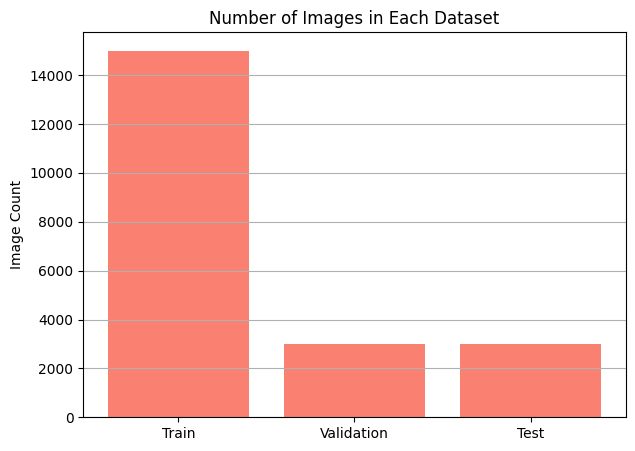

In [ ]:
# 데이터셋 별 전체 이미지 수 막대그래프

def count_images_in_directory(directory):
    total = 0
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir) # 각 클래스 폴더의 전체 경로 생성
        if os.path.isdir(class_path):
            total += len(os.listdir(class_path))
    return total

train_count = count_images_in_directory(train_path)
validation_count = count_images_in_directory(validation_path)
test_count = count_images_in_directory(test_path)

# 시각화
plt.figure(figsize=(7, 5))
plt.bar(['Train', 'Validation', 'Test'], [train_count, validation_count, test_count], color='salmon')
plt.title('Number of Images in Each Dataset')
plt.ylabel('Image Count')
plt.grid(axis='y')
plt.show()


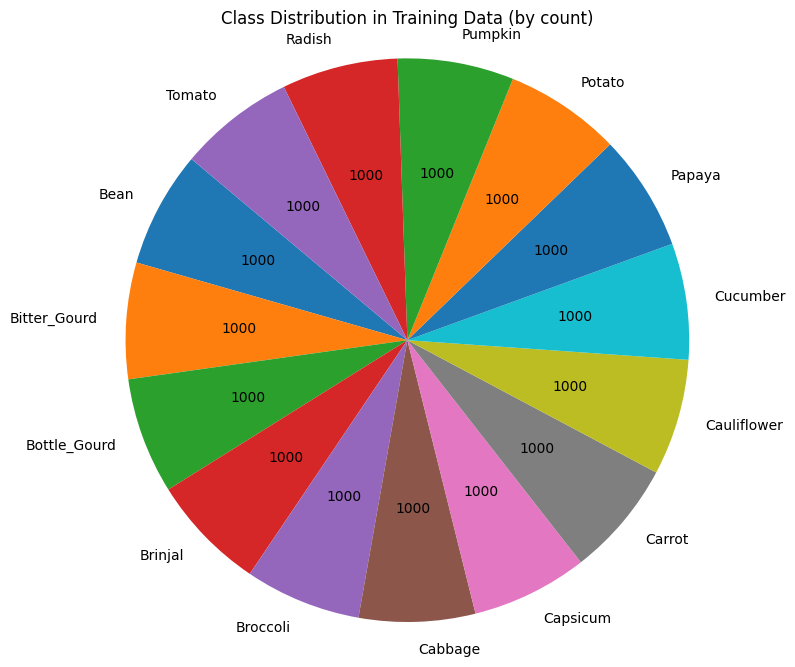

In [ ]:
# 클래스별 이미지 수 원형 그래프 (Train 기준)
class_counts = {}
for class_name in sorted(os.listdir(train_path)):
  class_dir = os.path.join(train_path, class_name)
  if os.path.isdir(class_dir):
    class_counts[class_name] = len(os.listdir(class_dir))

def show_counts(pct, all_vals):
    absolute = int(round(pct/100. * np.sum(all_vals)))
    return f'{absolute}'

# 시각화
plt.figure(figsize=(8, 8))
plt.pie(
    class_counts.values(),
    labels=class_counts.keys(),
    autopct=lambda pct: show_counts(pct, list(class_counts.values())),
    startangle=140
)
plt.title('Class Distribution in Training Data (by count)')
plt.axis('equal')
plt.show()

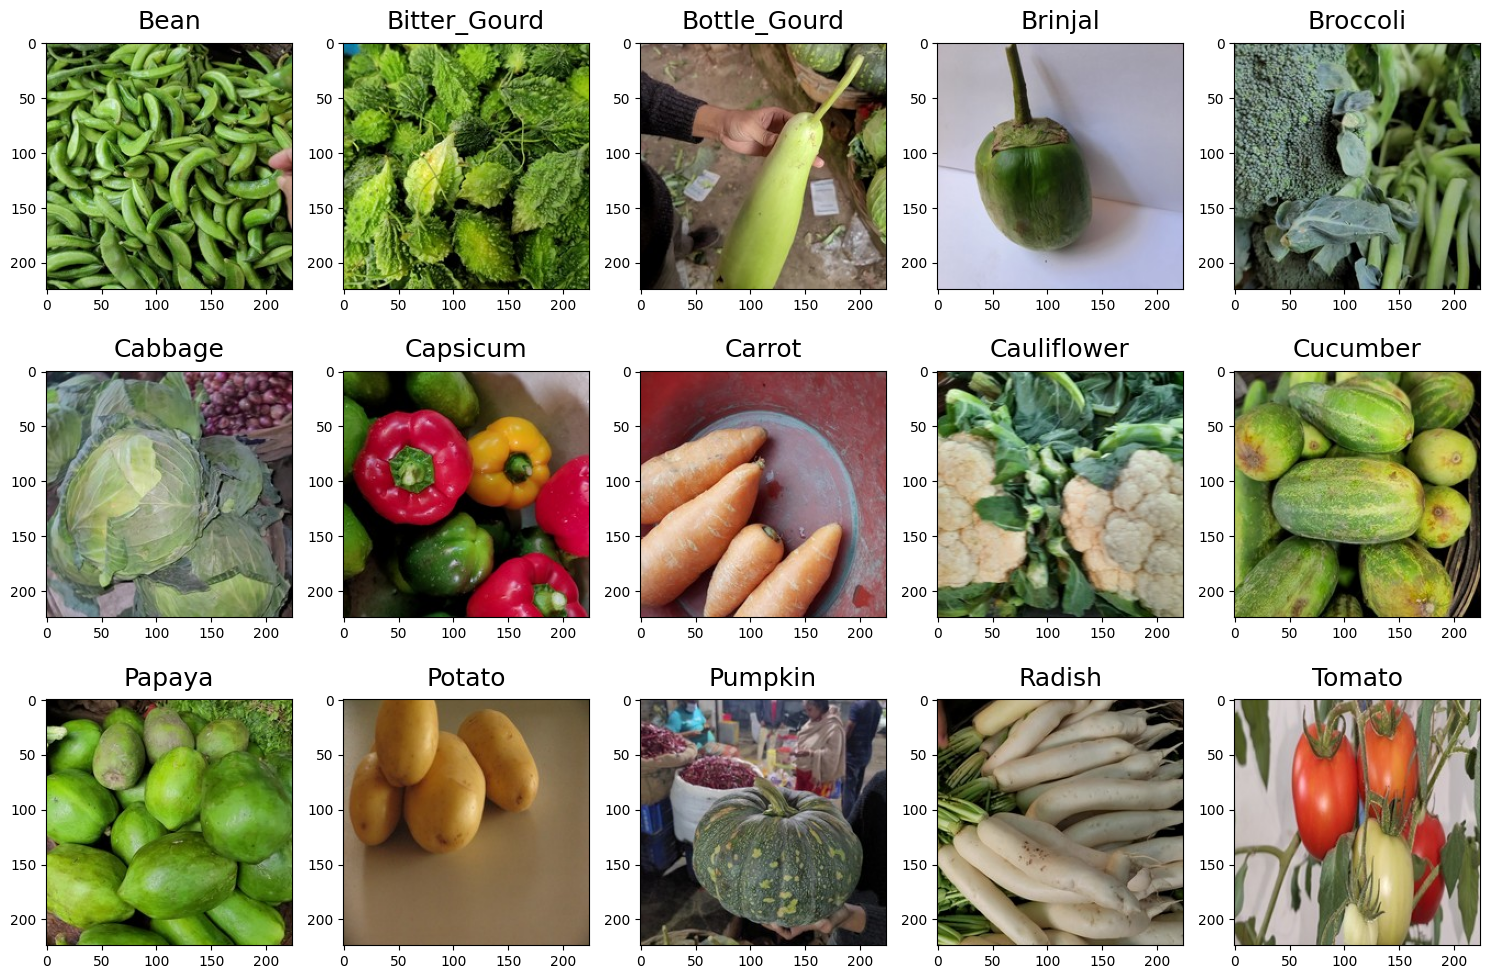

In [ ]:
images = []

class_names = sorted(os.listdir(train_path))

# 각 클래스에서 랜덤으로 이미지 1개 선택
for food_folder in class_names: #클래스 폴더 정렬
    food_items = os.listdir(train_path + '/' + food_folder) # 해당 폴더의 이미지 파일 리스트
    food_selected = np.random.choice(food_items) # 랜덤으로 1개 선택
    images.append(os.path.join(train_path,food_folder,food_selected)) # 이미지 경로 저장

# 그래프 설정
fig=plt.figure(1, figsize=(15, 10))

# 각 클래스 이미지 출력
for subplot,image_ in enumerate(images):
    category=image_.split('/')[-2] # 클래스명 추출
    imgs = plt.imread(image_) # 이미지 로드
    a,b,c=imgs.shape
    fig=plt.subplot(3, 5, subplot+1)
    fig.set_title(category, pad = 10,size=18)
    plt.imshow(imgs)

plt.tight_layout()

# [5. 모델 비교]



## [ResNet50V2]

In [ ]:
# ResNet50V2
res_base_model = ResNet50V2(input_shape=(256,256,3), include_top=False)
res_base_model.trainable = False

model_name = "ResNet50V2"
mysql_logger = MySQLLogger(model_name, conn, test_data=test_data)

res_model = Sequential([
    res_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_initializer='he_normal'),
    layers.Dense(num_classes, activation='softmax')], name=model_name)

early_stopping = EarlyStopping(
    patience=3,
    restore_best_weights = True)

model_checkpoint = ModelCheckpoint(model_name + ".h5", save_best_only=True)

callbacks = [early_stopping, model_checkpoint, mysql_logger]

res_model.summary()

Model: "ResNet50V2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 8, 8, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,093,199 (91.91 MB)

 Trainable params: 528,399 (2.02 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.9080 - loss: 0.3129

469/469 ━━━━━━━━━━━━━━━━━━━━ 255s 526ms/step - accuracy: 0.9081 - loss: 0.3125 - val_accuracy: 0.9927 - val_loss: 0.0249
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.9848 - loss: 0.0454

469/469 ━━━━━━━━━━━━━━━━━━━━ 238s 508ms/step - accuracy: 0.9848 - loss: 0.0454 - val_accuracy: 0.9970 - val_loss: 0.0103
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.9919 - loss: 0.0248

469/469 ━━━━━━━━━━━━━━━━━━━━ 239s 510ms/step - accuracy: 0.9919 - loss: 0.0248 - val_accuracy: 0.9967 - val_loss: 0.0094
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.9894 - loss: 0.0309

469/469 ━━━━━━━━━━━━━━━━━━━━ 238s 507ms/step - accuracy: 0.9894 - loss: 0.0309 - val_accuracy: 0.9977 - val_loss: 0.0085
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.9925 - loss: 0.0193

469/469 ━━━━━━━━━━━━━━━━━━━━ 240s 512ms/step - accuracy: 0.9925 - loss: 0.0193 - val_accuracy: 0.9973 - val_loss: 0.0083


94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.9958 - loss: 0.0201
Test Accuracy: 0.9960


KeyError: 'accuracy'

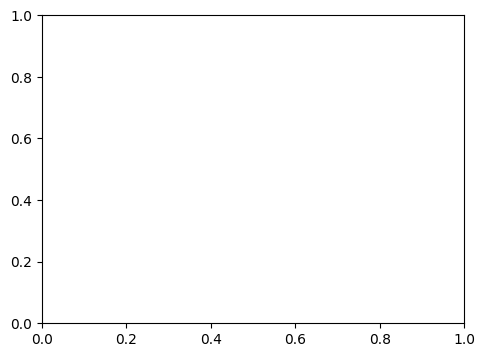

In [ ]:
res_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

res_history = res_model.fit(train_data,
                        validation_data=validation_data,
                        callbacks=callbacks,
                        epochs=5)

# 모델 저장
res_model.save("ResNet50V2_model_epoch10.h5")

# 모델 평가
test_loss, test_acc = res_model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.4f}")

In [ ]:
# 학습 과정 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(res_history.history['accuracy'], label='Train Accuracy')
plt.plot(res_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(res_history.history['loss'], label='Train Loss')
plt.plot(res_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

## [VGG16]

In [ ]:
#VGG16
vgg_base_model = VGG16(input_shape=(256,256,3), include_top=False)

model_name = "VGG16"
mysql_logger = MySQLLogger(model_name, conn, test_data=test_data)

vgg_model = Sequential([
    vgg_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')], name=model_name)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights = True)

model_checkpoint = ModelCheckpoint(model_name + ".h5", save_best_only=True)

callbacks = [early_stopping, model_checkpoint, mysql_logger]

vgg_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "VGG16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 8, 8, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,849,871 (56.65 MB)

 Trainable params: 14,849,871 (56.65 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 분류기만 학습
for layer in vgg_base_model.layers:
  layer.trainable = False

vgg_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

print("분류기만 학습 (Pre-trained Layer 고정)")

vgg_history = vgg_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=5,
    batch_size=32,
    callbacks=callbacks)

# 모델 저장
vgg_model.save("VGG16_model_epoch5.h5")

# 모델 평가
test_loss, test_acc = vgg_model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.4f}")

분류기만 학습 (Pre-trained Layer 고정)
Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.4826 - loss: 1.7105

469/469 ━━━━━━━━━━━━━━━━━━━━ 248s 523ms/step - accuracy: 0.4829 - loss: 1.7095 - val_accuracy: 0.8920 - val_loss: 0.4568
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.8184 - loss: 0.6330

469/469 ━━━━━━━━━━━━━━━━━━━━ 238s 508ms/step - accuracy: 0.8184 - loss: 0.6329 - val_accuracy: 0.9317 - val_loss: 0.2405
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.8741 - loss: 0.4261

469/469 ━━━━━━━━━━━━━━━━━━━━ 240s 512ms/step - accuracy: 0.8741 - loss: 0.4261 - val_accuracy: 0.9553 - val_loss: 0.1753
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.9065 - loss: 0.3277

469/469 ━━━━━━━━━━━━━━━━━━━━ 240s 511ms/step - accuracy: 0.9065 - loss: 0.3277 - val_accuracy: 0.9653 - val_loss: 0.1321
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.9242 - loss: 0.2685

469/469 ━━━━━━━━━━━━━━━━━━━━ 238s 506ms/step - accuracy: 0.9242 - loss: 0.2685 - val_accuracy: 0.9753 - val_loss: 0.0935


94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9844 - loss: 0.0721
Test Accuracy: 0.9783


In [ ]:
# 부분 Fine-Tuning
for layer in vgg_base_model.layers[-4:]:
    layer.trainable = True

vgg_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

print("부분 Fine-Tuning 진행 (상위 레이어만 학습)")

vgg_partial_finetune = vgg_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=5,
    batch_size=32,
    callbacks=[early_stopping])

pd.DataFrame(vgg_partial_finetune.history)

부분 Fine-Tuning 진행 (상위 레이어만 학습)
Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 251s 517ms/step - accuracy: 0.9964 - loss: 0.0139 - val_accuracy: 0.9987 - val_loss: 0.0068
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 234s 500ms/step - accuracy: 0.9983 - loss: 0.0055 - val_accuracy: 0.9997 - val_loss: 0.0035
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 234s 498ms/step - accuracy: 0.9975 - loss: 0.0074 - val_accuracy: 0.9997 - val_loss: 0.0027
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 234s 499ms/step - accuracy: 0.9981 - loss: 0.0068 - val_accuracy: 0.9983 - val_loss: 0.0043
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 235s 501ms/step - accuracy: 0.9982 - loss: 0.0050 - val_accuracy: 0.9983 - val_loss: 0.0095


,accuracy,loss,val_accuracy,val_loss
0,0.996800,0.011246,0.998667,0.006816
1,0.997600,0.007360,0.999667,0.003503
2,0.997467,0.008701,0.999667,0.002741
3,0.998467,0.005212,0.998333,0.004263
4,0.998000,0.005732,0.998333,0.009511


In [ ]:
# Full Fine-Tuning
for layer in vgg_base_model.layers:
  layer.trainable = True

# 전체 네트워크 학습
vgg_model.compile(
    optimizer=Adam (learning_rate=1e-4),
    loss = 'categorical_crossentropy',
    metrics=['accuracy'])

print("Full Fine-Tuning 진행")

vgg_finetune = vgg_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=5,
    batch_size=32,
    callbacks=callbacks)

Full Fine-Tuning 진행
Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.7996 - loss: 0.9679

469/469 ━━━━━━━━━━━━━━━━━━━━ 250s 514ms/step - accuracy: 0.7998 - loss: 0.9667 - val_accuracy: 0.9840 - val_loss: 0.0464
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.9602 - loss: 0.1387

469/469 ━━━━━━━━━━━━━━━━━━━━ 235s 502ms/step - accuracy: 0.9602 - loss: 0.1387 - val_accuracy: 0.9910 - val_loss: 0.0281
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 234s 498ms/step - accuracy: 0.9764 - loss: 0.0823 - val_accuracy: 0.9903 - val_loss: 0.0313
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.9723 - loss: 0.0941

469/469 ━━━━━━━━━━━━━━━━━━━━ 238s 508ms/step - accuracy: 0.9723 - loss: 0.0941 - val_accuracy: 0.9967 - val_loss: 0.0126
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 233s 496ms/step - accuracy: 0.9853 - loss: 0.0545 - val_accuracy: 0.9803 - val_loss: 0.0660


## [MobileNet]

In [ ]:
#MobileNet
mob_base_model = MobileNetV2(input_shape=(256,256,3), include_top=False)

model_name = "MobileNetV2"
mysql_logger = MySQLLogger(model_name, conn, test_data=test_data)

mob_model = Sequential([
    mob_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')], name=model_name)

mob_model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights = True)

model_checkpoint = ModelCheckpoint(model_name + ".h5", save_best_only=True)

callbacks = [early_stopping, model_checkpoint,mysql_logger]

<ipython-input-42-5bf8df8056b0>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mob_base_model = MobileNetV2(input_shape=(256,256,3), include_top=False)


Model: "MobileNetV2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 8, 8, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 15)                  │             975 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,947,663 (11.24 MB)

 Trainable params: 2,913,551 (11.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
# 분류기만 학습
for layer in mob_base_model.layers:
  layer.trainable = False

mob_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

print("분류기만 학습 (Pre-trained Layer 고정)")

mob_history = mob_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=5,
    batch_size=32,
    callbacks=callbacks)

# 모델 저장
mob_model.save("MobileNetV2_model_epoch5.h5")

# 모델 평가
test_loss, test_acc = mob_model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.4f}")

분류기만 학습 (Pre-trained Layer 고정)
Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.7308 - loss: 0.8688

469/469 ━━━━━━━━━━━━━━━━━━━━ 274s 545ms/step - accuracy: 0.7310 - loss: 0.8678 - val_accuracy: 0.9890 - val_loss: 0.0289
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.9606 - loss: 0.1418

469/469 ━━━━━━━━━━━━━━━━━━━━ 238s 507ms/step - accuracy: 0.9607 - loss: 0.1418 - val_accuracy: 0.9907 - val_loss: 0.0284
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.9748 - loss: 0.0880

469/469 ━━━━━━━━━━━━━━━━━━━━ 238s 507ms/step - accuracy: 0.9748 - loss: 0.0880 - val_accuracy: 0.9970 - val_loss: 0.0079
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.9832 - loss: 0.0636

469/469 ━━━━━━━━━━━━━━━━━━━━ 238s 507ms/step - accuracy: 0.9832 - loss: 0.0636 - val_accuracy: 0.9987 - val_loss: 0.0061
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 237s 506ms/step - accuracy: 0.9863 - loss: 0.0532 - val_accuracy: 0.9977 - val_loss: 0.0071


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9967 - loss: 0.0097
Test Accuracy: 0.9970


# [6. 모델 평가]

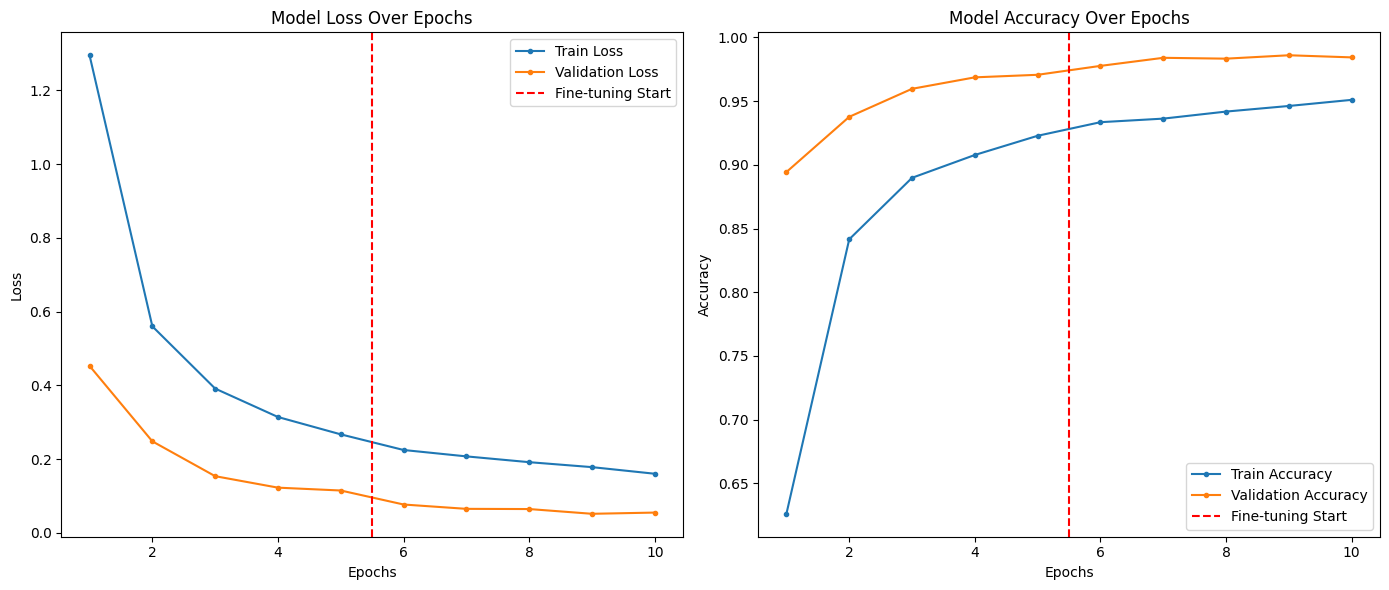

In [ ]:
def plot_full_training_history(history1, history2):
    train_loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']
    train_acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']

    # 훈련 단계 구분선 위치
    stage_change = len(history1.history['loss'])
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(14, 6))

    # 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss', marker='o', markersize=3)
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o', markersize=3)
    plt.axvline(x=stage_change + 0.5, color='r', linestyle='--', label='Fine-tuning Start')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss Over Epochs')
    plt.legend()

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train Accuracy', marker='o', markersize=3)
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o', markersize=3)
    plt.axvline(x=stage_change + 0.5, color='r', linestyle='--', label='Fine-tuning Start')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 전체 학습 과정 시각화
plot_full_training_history(vgg_history, vgg_finetune)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━

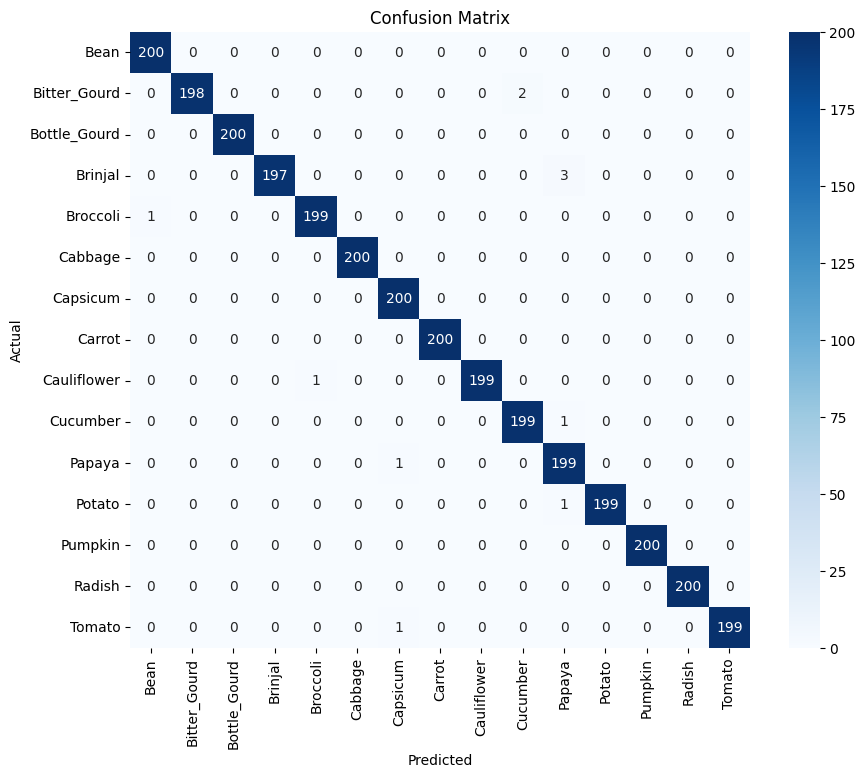


Classification Report:

              precision    recall  f1-score   support

        Bean       1.00      1.00      1.00       200
Bitter_Gourd       1.00      0.99      0.99       200
Bottle_Gourd       1.00      1.00      1.00       200
     Brinjal       1.00      0.98      0.99       200
    Broccoli       0.99      0.99      0.99       200
     Cabbage       1.00      1.00      1.00       200
    Capsicum       0.99      1.00      1.00       200
      Carrot       1.00      1.00      1.00       200
 Cauliflower       1.00      0.99      1.00       200
    Cucumber       0.99      0.99      0.99       200
      Papaya       0.98      0.99      0.99       200
      Potato       1.00      0.99      1.00       200
     Pumpkin       1.00      1.00      1.00       200
      Radish       1.00      1.00      1.00       200
      Tomato       1.00      0.99      1.00       200

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
w

In [ ]:
# 전체 테스트 데이터 예측
y_true = []
y_pred = []

for images, labels in test_data:
    preds = res_model.predict(images)
    y_true.extend(np.argmax(labels, axis=1))  # 실제 클래스 (one-hot → index 변환)
    y_pred.extend(np.argmax(preds, axis=1))  # 예측된 클래스

    if len(y_true) >= test_data.samples:  # 전체 데이터 수만큼만 가져오기
        break

# 클래스별 인덱스 매핑
class_indices = train_data.class_indices
class_names = {v: k for k, v in class_indices.items()}  # 인덱스를 클래스명으로 변환

# 혼동 행렬 계산
cm = confusion_matrix(y_true, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names.values(), yticklabels=class_names.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 분류 리포트 출력 (정확도, 정밀도, 재현율, F1-score)
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names.values()))


# [7. 결론]

In [ ]:
pd.DataFrame(res_history.history)

,accuracy,loss,val_accuracy,val_loss
0,0.965467,0.114778,0.997000,0.013138
1,0.987867,0.036640,0.991667,0.023958
2,0.989533,0.033150,0.998000,0.011353
3,0.993200,0.020492,0.997000,0.010990
4,0.992667,0.022978,0.996667,0.007727


In [ ]:
pd.DataFrame(vgg_history.history)

,accuracy,loss,val_accuracy,val_loss
0,0.614333,1.317702,0.886333,0.471047
1,0.834000,0.581409,0.940000,0.245960
2,0.883800,0.415110,0.956667,0.166766
3,0.904867,0.326190,0.965667,0.134530
4,0.915733,0.280384,0.972000,0.105363


In [ ]:
pd.DataFrame(vgg_partial_finetune.history)

,accuracy,loss,val_accuracy,val_loss
0,0.996800,0.011246,0.998667,0.006816
1,0.997600,0.007360,0.999667,0.003503
2,0.997467,0.008701,0.999667,0.002741
3,0.998467,0.005212,0.998333,0.004263
4,0.998000,0.005732,0.998333,0.009511


In [ ]:
pd.DataFrame(vgg_finetune.history)

,accuracy,loss,val_accuracy,val_loss
0,0.901200,0.392464,0.984000,0.046362
1,0.956600,0.156924,0.991000,0.028119
2,0.978200,0.078113,0.990333,0.031314
3,0.972533,0.097931,0.996667,0.012568
4,0.981200,0.069907,0.980333,0.066027


In [ ]:
pd.DataFrame(mob_history.history)

,accuracy,loss,val_accuracy,val_loss
0,0.981467,0.070309,0.990000,0.030423
1,0.986667,0.051027,0.993333,0.022069
2,0.988133,0.042702,0.993000,0.024417
3,0.989867,0.037291,0.995333,0.019960
4,0.990000,0.034552,0.996333,0.013687


# [8. 데이터베이스 조회]

In [ ]:
query = """
SELECT model_name, epoch, start_time, end_time, loss, accuracy, val_loss, val_accuracy, test_loss
FROM training_logs
"""

df = pd.read_sql(query, conn)
conn.close()

df

<ipython-input-49-172a5211ea36>:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,model_name,epoch,start_time,end_time,loss,accuracy,val_loss,val_accuracy,test_loss
0,ResNet50V2,1,2025-03-25 02:45:03,2025-03-25 02:49:17,0.125183,0.963000,0.024895,0.992667,NaN
1,ResNet50V2,2,2025-03-25 02:49:18,2025-03-25 02:53:16,0.036260,0.988400,0.010322,0.997000,NaN
2,ResNet50V2,3,2025-03-25 02:53:17,2025-03-25 02:57:16,0.028004,0.991067,0.009395,0.996667,NaN
3,ResNet50V2,4,2025-03-25 02:57:16,2025-03-25 03:01:13,0.027544,0.990267,0.008473,0.997667,NaN
4,ResNet50V2,5,2025-03-25 03:01:14,2025-03-25 03:05:13,0.019863,0.993400,0.008299,0.997333,0.014798
5,VGG16,1,2025-03-25 03:46:27,2025-03-25 03:50:35,1.234390,0.640667,0.456787,0.892000,NaN
6,VGG16,2,2025-03-25 03:50:35,2025-03-25 03:54:33,0.553476,0.842800,0.240482,0.931667,NaN
7,VGG16,3,2025-03-25 03:54:34,2025-03-25 03:58:34,0.395699,0.882867,0.175350,0.955333,NaN
8,VGG16,4,2025-03-25 03:58:34,2025-03-25 04:02:33,0.316833,0.907600,0.132144,0.965333,NaN
9,VGG16,5,2025-03-25 04:02:34,2025-03-25 04:06:31,0.261099,0.925733,0.093538,0.975333,0.090638
